In [1]:
%env  WORKDIR=/tmp/vault

env: WORKDIR=/tmp/vault


In [2]:
%%bash
cat $WORKDIR/VAULT_TOKEN.TXT
cat $WORKDIR/VAULT_ADDR.TXT

hvs.QbtInWOOYqrZJnMrDmcaArKs
https://vault-primary-europe-southwest1-jlhb.josemerchan-f986bf.gcp.sbx.hashicorpdemo.com:8200


In [3]:
%env VAULT_ADDR=https://vault-primary-europe-southwest1-jlhb.josemerchan-f986bf.gcp.sbx.hashicorpdemo.com:8200
%env VAULT_TOKEN=hvs.QbtInWOOYqrZJnMrDmcaArKs

env: VAULT_ADDR=https://vault-primary-europe-southwest1-jlhb.josemerchan-f986bf.gcp.sbx.hashicorpdemo.com:8200
env: VAULT_TOKEN=hvs.QbtInWOOYqrZJnMrDmcaArKs


## Enable LDAP Secret Engine

In [4]:
%%bash
vault secrets enable ldap

Success! Enabled the ldap secrets engine at: ldap/


## Connect to LDAP with username (bindDN) and password

In [5]:
%%bash
export LDAP_ADDR=$(kubectl get svc -n openldap openldap -o json | jq  -r '.status.loadBalancer.ingress[0].ip')
vault write ldap/config \
    binddn=cn=admin,dc=learn,dc=example \
    bindpass="Passw0rd123!" \
    url=ldap://$LDAP_ADDR:389


Success! Data written to: ldap/config


## Create a Role (Static Role)

In [6]:
%%bash
# Automatic Rotation
vault write ldap/static-role/learn \
    dn='cn=serviceaccount,ou=users,dc=learn,dc=example' \
    username='serviceaccount' \
    rotation_period="1h"


Success! Data written to: ldap/static-role/learn


## Request credential via CLI

In [7]:
%%bash
vault read ldap/static-cred/learn

Key                    Value
---                    -----
dn                     cn=serviceaccount,ou=users,dc=learn,dc=example
last_password          n/a
last_vault_rotation    2024-11-18T13:51:05.269135616Z
password               sJeQ9eYvinodvLMCjDth3novF4qU9Cad1JvlTePTwaw3Q8eU3TNUXFYyEB2VWEMV
rotation_period        1h
ttl                    59m57s
username               serviceaccount


## Request credential via API

In [8]:
%%bash
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request GET \
    --silent \
    $VAULT_ADDR/v1/ldap/static-cred/learn | jq . -r


{
  "request_id": "38aeb478-7450-cf99-20b1-bd7f8018761d",
  "lease_id": "",
  "renewable": false,
  "lease_duration": 0,
  "data": {
    "dn": "cn=serviceaccount,ou=users,dc=learn,dc=example",
    "last_password": "",
    "last_vault_rotation": "2024-11-18T13:51:05.269135616Z",
    "password": "sJeQ9eYvinodvLMCjDth3novF4qU9Cad1JvlTePTwaw3Q8eU3TNUXFYyEB2VWEMV",
    "rotation_period": 3600,
    "ttl": 3577,
    "username": "serviceaccount"
  },
  "wrap_info": null,
  "warnings": null,
  "auth": null,
  "mount_type": "ldap"
}


In [9]:
%%bash
vault read ldap/static-cred/learn
# Credetials are rotated in a lazy manner, ttl gets reduced, once it comes to 0 with the next request credential are rotated

Key                    Value
---                    -----
dn                     cn=serviceaccount,ou=users,dc=learn,dc=example
last_password          n/a
last_vault_rotation    2024-11-18T13:51:05.269135616Z
password               sJeQ9eYvinodvLMCjDth3novF4qU9Cad1JvlTePTwaw3Q8eU3TNUXFYyEB2VWEMV
rotation_period        1h
ttl                    59m24s
username               serviceaccount


In [10]:
%%bash
# Manual rotation
vault write -f ldap/rotate-role/learn

Success! Data written to: ldap/rotate-role/learn


In [11]:
%%bash
vault read ldap/static-cred/learn
# Credetials are rotated in a lazy manner, ttl gets reduced, once it comes to 0 with the next request credential are rotated

Key                    Value
---                    -----
dn                     cn=serviceaccount,ou=users,dc=learn,dc=example
last_password          sJeQ9eYvinodvLMCjDth3novF4qU9Cad1JvlTePTwaw3Q8eU3TNUXFYyEB2VWEMV
last_vault_rotation    2024-11-18T13:51:46.713455451Z
password               3oUCjAfeJjJ5TeTKdg2LkoEGwO3NkK4nlWaObEC8RR7cM212Po6jH3ssf0T7gl8z
rotation_period        1h
ttl                    59m57s
username               serviceaccount


## Connecting to LDAP with the static role password

In [12]:
%%bash
LDAP_PASSWORD=$(vault read --format=json ldap/static-cred/learn | jq -r ".data.password")  
LDAP_ADDR=$(kubectl get svc -n openldap openldap -o json | jq  -r '.status.loadBalancer.ingress[0].ip')

ldapsearch -p 389 -h $LDAP_ADDR -b "cn=serviceaccount,ou=users,dc=learn,dc=example" \
    -D 'cn=serviceaccount,ou=users,dc=learn,dc=example' \
    -w $LDAP_PASSWORD

# extended LDIF
#
# LDAPv3
# base <cn=serviceaccount,ou=users,dc=learn,dc=example> with scope subtree
# filter: (objectclass=*)
# requesting: ALL
#

# serviceaccount, users, learn.example
dn: cn=serviceaccount,ou=users,dc=learn,dc=example
objectClass: person
objectClass: top
sn: serviceaccount
cn: serviceaccount
userPassword:: M29VQ2pBZmVKako1VGVUS2RnMkxrb0VHd08zTmtLNG5sV2FPYkVDOFJSN2NNMjE
 yUG82akgzc3NmMFQ3Z2w4eg==

# search result
search: 2
result: 0 Success

# numResponses: 2
# numEntries: 1


## Dynamic Credentials

In [13]:
%%bash
cat > ${WORKDIR}/creation.ldif <<EOF
dn: uid={{.Username}},ou=users,dc=learn,dc=example
objectClass: inetOrgPerson
uid: {{.Username}}
cn: {{.Username}}
sn: {{.Username}}
userPassword: {{.Password}}
EOF

In [14]:
%%bash
cat > ${WORKDIR}/deletion_rollback.ldif <<EOF
dn: uid={{.Username}},ou=users,dc=learn,dc=example
changetype: delete
EOF

In [15]:
%%bash
# Dynamic Role
vault write ldap/role/dynamic \
     creation_ldif=@${WORKDIR}/creation.ldif \
     deletion_ldif=@${WORKDIR}/deletion_rollback.ldif \
     rollback_ldif=@${WORKDIR}/deletion_rollback.ldif \
     default_ttl=1h

Success! Data written to: ldap/role/dynamic


In [16]:
%%bash
vault read ldap/creds/dynamic

Key                    Value
---                    -----
lease_id               ldap/creds/dynamic/nqhfl5YUqeU1EpOQuMpsekJC
lease_duration         1h
lease_renewable        true
distinguished_names    [uid=v_root_dynamic_t6EP8d7GEC_1731937958,ou=users,dc=learn,dc=example]
password               KRtc5kNNm9ugMHfUekNIX42C08jhN663itsNmXgFf1UbZ5bcrVUmYuJh6PDm7gy3
username               v_root_dynamic_t6EP8d7GEC_1731937958


In [17]:
%%bash
curl -k --header "X-Vault-Token: $VAULT_TOKEN" --request GET --silent $VAULT_ADDR/v1/ldap/creds/dynamic | jq

{
  "request_id": "8ba1fa4e-93db-ad8f-25d5-dc6daea9e8ba",
  "lease_id": "ldap/creds/dynamic/9lIwYRIDhPbft3GzM2winpTj",
  "renewable": true,
  "lease_duration": 3600,
  "data": {
    "distinguished_names": [
      "uid=v_root_dynamic_d1ZN7DF7Fk_1731938026,ou=users,dc=learn,dc=example"
    ],
    "password": "89R2Tj7j0ceB8i9bqgoHsKUj7oDWSzFmbwobNJXMGUB60yPP7p9i1EIu4hm8ypUJ",
    "username": "v_root_dynamic_d1ZN7DF7Fk_1731938026"
  },
  "wrap_info": null,
  "warnings": null,
  "auth": null,
  "mount_type": "ldap"
}


In [18]:
%%bash
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request GET \
    --silent \
    $VAULT_ADDR/v1/ldap/creds/dynamic \
    | jq . -r

{
  "request_id": "4e025d36-cebc-e3c0-398e-b5d4808e81e3",
  "lease_id": "ldap/creds/dynamic/isOZuIrUrzJcOhH50hlT3ADs",
  "renewable": true,
  "lease_duration": 3600,
  "data": {
    "distinguished_names": [
      "uid=v_root_dynamic_aOk86ZS5Qa_1731938031,ou=users,dc=learn,dc=example"
    ],
    "password": "0y2JJcmiv1yxWpMCxzBAbrDyDM4RN3rNpGQtbiMd1n7O7OdfNYeNT20KFCl3UhVR",
    "username": "v_root_dynamic_aOk86ZS5Qa_1731938031"
  },
  "wrap_info": null,
  "warnings": null,
  "auth": null,
  "mount_type": "ldap"
}


## Lista de cuentas dinámicas creadas

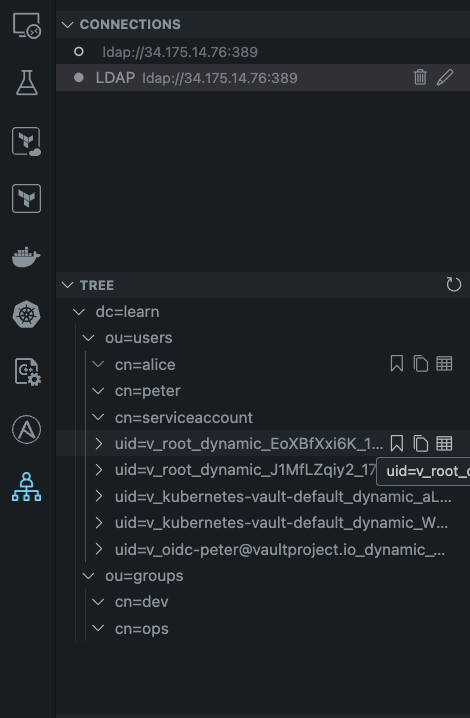

In [19]:
%%bash
## Check leases in Vault
vault list sys/leases/lookup/ldap/creds/dynamic

Keys
----
9lIwYRIDhPbft3GzM2winpTj
isOZuIrUrzJcOhH50hlT3ADs
nqhfl5YUqeU1EpOQuMpsekJC


In [20]:
%%bash
## Revoke individual token
vault lease revoke ldap/creds/dynamic/\
$(vault list -format=json sys/leases/lookup/ldap/creds/dynamic | jq -r .[0])
vault list sys/leases/lookup/ldap/creds/dynamic

All revocation operations queued successfully!
Keys
----
isOZuIrUrzJcOhH50hlT3ADs
nqhfl5YUqeU1EpOQuMpsekJC


In [21]:
%%bash
## Elimino todas las cuentas creadas
vault lease revoke -prefix ldap/creds/dynamic

All revocation operations queued successfully!
